# Easy Money - Modelo de propensión a compra

Mensaje de Carol: Una vez que hayamos hecho el análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a comprar nuestros productos así que te pido por favor hagas un modelo de propensión a compra, se que tenemos muchos productos, así que te dejo a tu criterio científico qué productos elegir, o pueden ser varios, ya me sorprenderás

Vamos a desarrollar un modelo capaz de **predecir si un cliente es propenso a contratar un producto de Easy Money, teniendo en cuenta sus características**.

## Importación de librerías

In [853]:
# Importamos las librerias necesarias.
import os
import pandas as pd
import numpy as np


from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
from sklearn import model_selection 
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [854]:
import matplotlib.pyplot as plt
import seaborn as sns

## Importación de datos

De las tablas que tenemos disponibles en BBDD, las que serán de utilidad para este modelo son customer_sociodemographics, customer_commercial_activity y sales. 
<p>Guardamos los datos de las tablas en dataframes distintos que limpiaremos, y posteriormente uniremos en un único dataframe 


In [855]:
# Obtener el directorio de trabajo actual
current_dir = os.getcwd()

# Ir a la carpeta anterior del directorio actual porque ahí se encuentra la carpeta 'data' donde están todos los ficheros .csv
parent_dir = os.path.dirname(current_dir)

DATA_PATH = os.path.join(parent_dir, 'data/') # Ruta donde están los ficheros .csv

FILE_NAME1 = 'customer_sociodemographics.csv'
FILE1 = os.path.join(DATA_PATH, FILE_NAME1)

FILE_NAME2 = 'customer_commercial_activity.csv'
FILE2 = os.path.join(DATA_PATH, FILE_NAME2)

FILE_NAME3 = 'sales.csv'
FILE3 = os.path.join(DATA_PATH, FILE_NAME3)

FILE_NAME4 = 'customer_products.csv'
FILE4 = os.path.join(DATA_PATH, FILE_NAME4)

print('current path:', current_dir)
print('parent path:', parent_dir)
print('data path:', DATA_PATH)
print('file 1:', FILE1)
print('file 2:', FILE2)
print('file 3:', FILE3)
print('file 4:', FILE4)
print('data path:', DATA_PATH)

current path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/clustering
parent path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/
file 1: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_sociodemographics.csv
file 2: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_commercial_activity.csv
file 3: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/sales.csv
file 4: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/customer_products.csv
data path: /Users/alinaoganesyan/Desktop/Master Data Science/Entregables/Proyecto final/git-proyecto/data/


In [856]:
df_cs = pd.read_csv(FILE1, index_col=0)
df_cca = pd.read_csv(FILE2, index_col=0)
df_sales = pd.read_csv(FILE3, index_col=0)
df_customer_products = pd.read_csv(FILE4, index_col=0)

## 1: Data Understanding

### 1.1: Análisis Univariante de datos de las distintos datasets que vamos a usar

#### 1.1.1 Analizamos la tabla customer_sociodemographics

In [857]:
# Datos generales 

df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   pk_cid        int64  
 1   pk_partition  object 
 2   country_id    object 
 3   region_code   float64
 4   gender        object 
 5   age           int64  
 6   deceased      object 
 7   salary        float64
dtypes: float64(2), int64(2), object(4)
memory usage: 409.4+ MB


In [858]:
# Visualización de los datos
df_cs.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [859]:
# Recuento de nulos 

df_cs.isna().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

De entrada, analizamos la columna "deceased" para eliminar los clientes fallecidos y quedarnos con aquellos que actualmente son reales

In [860]:
df_cs['deceased'].value_counts()

deceased
N    5961849
S       1075
Name: count, dtype: int64

In [861]:
df_cs = df_cs[(df_cs['deceased']  == 'N')]
df_cs['deceased'].value_counts()

deceased
N    5961849
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes no fallecidos, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [862]:
del(df_cs['deceased'])

Analizamos también la columna country_id para ver si vale la pena quedarnos con todos los países de la BBDD 

In [863]:
df_cs['country_id'].value_counts()

country_id
ES    5959602
GB        441
FR        225
DE        199
US        195
CH        189
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: count, dtype: int64

Vemos que los valores de los países distintos a ES son muy pequeños y no aportarán demasiado valor a nuestro modelo. Nos quedamos solamente con los registros que son country_id = ES

In [864]:
df_cs = df_cs[(df_cs['country_id']  == 'ES')]
df_cs['country_id'].value_counts()

country_id
ES    5959602
Name: count, dtype: int64

Ahora que nos hemos quedado solamente con los clientes de ES, esta columna no es de mucha utilidad ya que siempre tiene el mismo valor. La podemos eliminar.

In [865]:
del(df_cs['country_id'])

Según el diccionario de las tablas, region_code es el código de provincia. Este dato sí puede ser relevante, pero vemos que tiene nulos. Como estamos ante un modelo de clasificación binaria, podemos rellenar los nulos con un valor como -1, para que se sean agrupados en un bloque propio.

In [866]:
df_cs['region_code'].fillna(-1, inplace=True)

La columna gender también tenía nulos, pero son muy pocos en relación al total del dataset. Analizamos cuántos nulos quedan después de los cambios ya realizados y elimnamos estas filas por ser muy pocas

In [867]:
df_cs['gender'].isna().sum()

25

In [868]:
df_cs = df_cs.dropna(subset =['gender'])

Analizamos la columna salary 

In [869]:
df_cs['salary'].value_counts()

salary
451931.22    709
288997.44    546
135522.15    466
128318.52    458
104563.80    436
            ... 
127111.23      1
100303.05      1
125135.46      1
188185.68      1
167276.64      1
Name: count, Length: 257626, dtype: int64

In [870]:
df_cs['salary'].describe()

count    4.420911e+06
mean     1.155810e+05
std      2.000189e+05
min      1.202730e+03
25%      6.141354e+04
50%      8.843742e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64

Vemos que todos los valores son positivos, que la diferencia entre el salario mayor y el salario menor es muy grande, y que la media por tanto es muy elevada también. Igualmente, según el diccionario de la BBDD, se trata del salario de la unidad familiar y consideramos que este valor es importante a la hora de determinar la contratación. Al haber muchos nulos, y al ser el modelo de clasificación binaria, vamos a asignar a los nulos el valor -1

In [871]:
df_cs['salary'].fillna(-1, inplace=True)

Transformamos la columna region_code de float a int

In [872]:
df_cs["region_code"] = df_cs["region_code"].astype(int)

Transformamos la columna pk_partition a fecha

In [873]:
df_cs["pk_partition"] = pd.to_datetime(df_cs["pk_partition"])


Finalmente, la tabla de customer_sociodemographics quedará así:

In [874]:
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5959577 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   pk_cid        int64         
 1   pk_partition  datetime64[ns]
 2   region_code   int64         
 3   gender        object        
 4   age           int64         
 5   salary        float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 318.3+ MB


#### 1.1.2 Analizamos la tabla customer_commercial_activity

In [875]:
# Datos generales 

df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   pk_cid           int64  
 1   pk_partition     object 
 2   entry_date       object 
 3   entry_channel    object 
 4   active_customer  float64
 5   segment          object 
dtypes: float64(1), int64(1), object(4)
memory usage: 318.5+ MB


In [876]:
# Visualización de los datos
df_cca.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [877]:
# Recuento de nulos 

df_cca.isna().sum()

pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [878]:
pd.set_option('display.max_rows', 100)

In [879]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE    53.413469
KFC    15.276786
KHQ    10.125061
KAT     7.137080
KHK     3.948564
KHM     3.029062
KHN     1.859966
KFA     1.355428
KHD     1.301894
RED     1.039488
KHL     0.715897
KHF     0.354329
KHO     0.141461
KAZ     0.096657
KHC     0.089899
KBG     0.028508
KEH     0.012487
KHP     0.011853
007     0.010515
013     0.006810
KAG     0.005746
KAS     0.005232
KBZ     0.003396
KAA     0.003311
KAR     0.002693
KAY     0.002556
KAF     0.002110
KAB     0.001630
KFD     0.001561
KCC     0.001527
KAW     0.001115
KAQ     0.000892
KDH     0.000875
KAE     0.000823
KCH     0.000823
KCB     0.000806
KAD     0.000772
KAM     0.000738
KAH     0.000686
KAK     0.000583
KAJ     0.000566
KDT     0.000395
KFF     0.000377
KBO     0.000360
KEY     0.000343
KGC     0.000292
004     0.000292
KFS     0.000292
KCL     0.000292
KBE     0.000292
KBH     0.000292
KFK     0.000292
KGN     0.000292
KCI     0.000292
KGX     0.000292
KDR     0.000274
KFL     0.000223
KBW     0.000206


Vemos muchos valores de Entry Channel que son muy pocos en comparación con los valores mayoritarios. Elegimos los canales de entrada que tengan una proporción mayor al 1% y agrupamos el resto en Others

In [880]:
value_counts = (df_cca['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_cca['entry_channel'] = df_cca['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [881]:
df_cca['entry_channel'].value_counts(normalize = True)*100

entry_channel
KHE       53.413469
KFC       15.276786
KHQ       10.125061
KAT        7.137080
KHK        3.948564
KHM        3.029062
KHN        1.859966
Others     1.513202
KFA        1.355428
KHD        1.301894
RED        1.039488
Name: proportion, dtype: float64

Analizamos la columna segment para ver los valores únicos, sabiendo que también tiene nulos

In [882]:
df_cca['segment'].value_counts()

segment
03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: count, dtype: int64

Rellenamos NaN de channel y segment con un valor identificativo como 'Not defined'

In [883]:
df_cca["entry_channel"].fillna('Not defined', inplace=True)
df_cca["segment"].fillna('Not defined', inplace=True)

In [884]:
df_cca.isna().sum()

pk_cid             0
pk_partition       0
entry_date         0
entry_channel      0
active_customer    0
segment            0
dtype: int64

In [885]:
df_cca['active_customer'].value_counts()

active_customer
0.0    3557573
1.0    2405351
Name: count, dtype: int64

Transformarmos active_customer de float a int

In [886]:
df_cca["active_customer"] = df_cca["active_customer"].astype(int)

Transformamos las columna pk_partition y entry_date a fecha

In [887]:
df_cca["pk_partition"] = pd.to_datetime(df_cca["pk_partition"])
df_cca["entry_date"] = pd.to_datetime(df_cca["entry_date"])

Finalmente, la tabla de customer_commercial_activity quedará así:

In [888]:
df_cca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   pk_cid           int64         
 1   pk_partition     datetime64[ns]
 2   entry_date       datetime64[ns]
 3   entry_channel    object        
 4   active_customer  int64         
 5   segment          object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 318.5+ MB


#### 1.1.3 Analizamos la tabla sales

In [889]:
# Datos generales 

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240773 entries, 0 to 240772
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pk_sale     240773 non-null  int64  
 1   cid         240773 non-null  int64  
 2   month_sale  240773 non-null  object 
 3   product_ID  240773 non-null  int64  
 4   net_margin  240773 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 11.0+ MB


In [890]:
# Visualización de los datos
df_sales.head()

,pk_sale,cid,month_sale,product_ID,net_margin
0,6666,33620,2018-05-01,2335,952.9
1,6667,35063,2018-06-01,2335,1625.2
2,6668,37299,2018-02-01,2335,1279.7
3,6669,39997,2018-02-01,2335,1511.9
4,6670,44012,2018-02-01,2335,1680.3


In [891]:
# Recuento de nulos 

df_sales.isna().sum()

pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

La columna pk_sale es el identificador de la venta. Esta columna no va a ser necesaria para el modelo, por lo que la eliminamos.

In [892]:
del(df_sales['pk_sale'])

La clolumna net_margin nos puede ser útil para decidir qué producto elegir para la predicción de nuestro modelo, por lo que de momento la dejamos.

Transformamos la columna month_sale a fecha

In [893]:
df_sales["month_sale"] = pd.to_datetime(df_sales["month_sale"])

Finalmente, la tabla de sales quedará así:

In [894]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240773 entries, 0 to 240772
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cid         240773 non-null  int64         
 1   month_sale  240773 non-null  datetime64[ns]
 2   product_ID  240773 non-null  int64         
 3   net_margin  240773 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.2 MB


## 1.4 Analizamos el dataset de customer product

In [895]:
df_customer_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5962924 entries, 0 to 13647308
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   pk_cid              int64  
 1   pk_partition        object 
 2   short_term_deposit  int64  
 3   loans               int64  
 4   mortgage            int64  
 5   funds               int64  
 6   securities          int64  
 7   long_term_deposit   int64  
 8   em_account_pp       int64  
 9   credit_card         int64  
 10  payroll             float64
 11  pension_plan        float64
 12  payroll_account     int64  
 13  emc_account         int64  
 14  debit_card          int64  
 15  em_account_p        int64  
 16  em_acount           int64  
dtypes: float64(2), int64(14), object(1)
memory usage: 818.9+ MB


In [896]:
df_customer_products["pk_partition"] = pd.to_datetime(df_customer_products["pk_partition"] )

In [897]:
df_customer_products.isnull().sum()

pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [898]:
df_customer_products["payroll"]=df_customer_products["payroll"].fillna(0)
df_customer_products[ 'pension_plan']=df_customer_products[ 'pension_plan'].fillna(0)

In [899]:
df_customer_products.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
em_account_pp         0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
dtype: int64

## 2: Construcción del dataset para el modelo

Vamos a hacer un inner merge de todos los datasets, ya que nos interesa agrupar toda la información analizada en un único dataframe, que contenga toda la información por el id de cliente.

In [900]:
df_merged = pd.merge(
    left = df_cca, 
    right = df_cs,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [901]:
df_merged.head()

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary
0,1375586,2018-01-01,2018-01-01,Others,1,02 - PARTICULARES,29,H,35,87218.10
1,1050611,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,35548.74
2,1050612,2018-01-01,2015-08-01,KHE,0,03 - UNIVERSITARIO,13,V,23,122179.11
3,1050613,2018-01-01,2015-08-01,KHD,0,03 - UNIVERSITARIO,50,H,22,119775.54
4,1050614,2018-01-01,2015-08-01,KHE,1,03 - UNIVERSITARIO,50,V,23,-1.00


In [902]:
df_merged2 = pd.merge(
    left = df_merged, 
    right = df_customer_products,
    on = ('pk_cid', 'pk_partition'),
    how = 'inner')

In [903]:
pd.set_option('display.max_rows', 1000)

### Limpiamos todas las particiones menos la última 5-2019

In [904]:
df_merged2=df_merged2.loc[df_merged2['pk_partition'] =='2019-05']

In [905]:
df_merged2

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5516831,657826,2019-05-01,2015-05-01,Others,1,02 - PARTICULARES,25,H,44,54493.38,...,0,0,0,0.0,0.0,0,0,0,0,1
5516832,657817,2019-05-01,2019-05-01,Not defined,0,Not defined,8,V,32,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,0
5516833,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,0,0,1,1.0,1.0,1,1,1,0,0
5516834,657905,2019-05-01,2017-02-01,KAT,1,01 - TOP,28,H,85,154059.09,...,1,0,0,0.0,0.0,0,0,0,0,1
5516835,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959572,1166765,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,V,22,43912.17,...,0,0,0,0.0,0.0,0,0,0,0,1
5959573,1166764,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,26,V,23,23334.99,...,0,0,0,0.0,0.0,0,0,0,0,1
5959574,1166763,2019-05-01,2016-08-01,KHE,1,02 - PARTICULARES,50,H,47,-1.00,...,0,0,0,0.0,0.0,0,0,0,0,1
5959575,1166789,2019-05-01,2016-08-01,KHE,0,03 - UNIVERSITARIO,50,H,22,199592.82,...,0,0,0,0.0,0.0,0,0,0,0,1


Juntamos con la última partición de sales

In [906]:
df_merged3 = pd.merge(
    left = df_merged2, 
    right = df_sales,
    left_on = 'pk_cid',
    right_on  = 'cid',
    how = 'inner')

In [907]:
df_merged3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              236279 non-null  int64         
 1   pk_partition        236279 non-null  datetime64[ns]
 2   entry_date          236279 non-null  datetime64[ns]
 3   entry_channel       236279 non-null  object        
 4   active_customer     236279 non-null  int64         
 5   segment             236279 non-null  object        
 6   region_code         236279 non-null  int64         
 7   gender              236279 non-null  object        
 8   age                 236279 non-null  int64         
 9   salary              236279 non-null  float64       
 10  short_term_deposit  236279 non-null  int64         
 11  loans               236279 non-null  int64         
 12  mortgage            236279 non-null  int64         
 13  funds               236279 no

## Creamos datasets con los datos de clientes y productos

In [908]:
df_final = df_merged3.copy()

In [909]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pk_cid              236279 non-null  int64         
 1   pk_partition        236279 non-null  datetime64[ns]
 2   entry_date          236279 non-null  datetime64[ns]
 3   entry_channel       236279 non-null  object        
 4   active_customer     236279 non-null  int64         
 5   segment             236279 non-null  object        
 6   region_code         236279 non-null  int64         
 7   gender              236279 non-null  object        
 8   age                 236279 non-null  int64         
 9   salary              236279 non-null  float64       
 10  short_term_deposit  236279 non-null  int64         
 11  loans               236279 non-null  int64         
 12  mortgage            236279 non-null  int64         
 13  funds               236279 no

In [910]:
value_counts = (df_final['entry_channel'].value_counts(normalize = True, dropna=True)*100)
df_final['entry_channel'] = df_final['entry_channel'].apply(lambda x: x if pd.isna(x) or value_counts.get(x, 0) >= 1 else 'Others')

In [911]:
df_final['entry_channel'].value_counts()

entry_channel
KHQ       59998
KHM       42076
KFC       27559
KHN       26737
KHE       21955
KHK       20873
KAT       14198
Others    10211
RED        8720
KFA        3952
Name: count, dtype: int64

## Importamos librerías para empezar el modelo

In [912]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

In [913]:
RANDOM_STATE = 175  #Definimos la semilla

In [914]:
df_final.head(10)

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,region_code,gender,age,salary,...,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,cid,month_sale,product_ID,net_margin
0,657986,2019-05-01,2016-02-01,Others,1,02 - PARTICULARES,41,H,39,100993.17,...,1.0,1,1,1,0,0,657986,2018-03-01,2312,64.5
1,657336,2019-05-01,2019-03-01,KAT,1,02 - PARTICULARES,28,V,38,-1.00,...,0.0,0,0,0,0,1,657336,2019-04-01,4657,68.3
2,658184,2019-05-01,2015-05-01,KAT,1,02 - PARTICULARES,28,V,42,183036.72,...,1.0,1,1,1,0,0,658184,2018-03-01,3819,54.1
3,655774,2019-05-01,2018-12-01,KHN,1,02 - PARTICULARES,15,H,37,-1.00,...,0.0,0,0,0,0,1,655774,2019-01-01,4657,86.1
4,655419,2019-05-01,2016-05-01,KFC,0,02 - PARTICULARES,28,H,54,157268.85,...,0.0,0,0,0,0,0,655419,2018-06-01,4657,71.1
5,655682,2019-05-01,2018-06-01,KFC,1,02 - PARTICULARES,19,V,54,111293.31,...,0.0,0,0,1,0,1,655682,2018-10-01,3819,49.2
6,655682,2019-05-01,2018-06-01,KFC,1,02 - PARTICULARES,19,V,54,111293.31,...,0.0,0,0,1,0,1,655682,2018-06-01,4657,71.1
7,656163,2019-05-01,2018-06-01,KAT,1,02 - PARTICULARES,28,H,53,75408.45,...,0.0,0,1,0,0,1,656163,2018-07-01,8871,78.9
8,656163,2019-05-01,2018-06-01,KAT,1,02 - PARTICULARES,28,H,53,75408.45,...,0.0,0,1,0,0,1,656163,2018-07-01,4657,63.0
9,656915,2019-05-01,2018-01-01,Others,1,02 - PARTICULARES,33,V,37,134470.14,...,0.0,0,0,0,0,1,656915,2018-02-01,2335,1179.6


In [915]:
df_customer_products.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [916]:
column_names=df_customer_products.columns.tolist()

In [917]:
column_names

['pk_cid',
 'pk_partition',
 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [918]:
prod_list=[ 'short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_account_p',
 'em_acount']

In [919]:
df_final['total_products'] = df_final[prod_list].sum(axis=1)

In [920]:
df_final.head().T

,0,1,2,3,4
pk_cid,657986,657336,658184,655774,655419
pk_partition,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_date,2016-02-01 00:00:00,2019-03-01 00:00:00,2015-05-01 00:00:00,2018-12-01 00:00:00,2016-05-01 00:00:00
entry_channel,Others,KAT,KAT,KHN,KFC
active_customer,1,1,1,1,0
segment,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
region_code,41,28,28,15,28
gender,H,V,V,H,H
age,39,38,42,37,54
salary,100993.17,-1.0,183036.72,-1.0,157268.85


#### Meter diccionario con población de cada city
#### Tambien podemos meter tenencia por producto

Partimos del dataset de pagos y hacemos un groupby de order_id (identificador del pedido). Generamos las variables de:
- maximo pago del cliente
- minimo pago del cliente
- media pago del cliente
- total de pagos
- pagos secuenciales que ha llegado a hacer el cliente (aunque esta variable es confusa)

### Pasamos valores obj a num

In [921]:
object_columns = [col for col in df_final if df_final[col].dtype.kind == 'O']

In [922]:
for col in object_columns:
    _dummy_dataset = pd.get_dummies(df_final[col], prefix=col)
    df_final = pd.concat([df_final,_dummy_dataset],axis=1)
    df_final.drop([col],axis=1, inplace=True)

In [923]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      236279 non-null  int64         
 1   pk_partition                236279 non-null  datetime64[ns]
 2   entry_date                  236279 non-null  datetime64[ns]
 3   active_customer             236279 non-null  int64         
 4   region_code                 236279 non-null  int64         
 5   age                         236279 non-null  int64         
 6   salary                      236279 non-null  float64       
 7   short_term_deposit          236279 non-null  int64         
 8   loans                       236279 non-null  int64         
 9   mortgage                    236279 non-null  int64         
 10  funds                       236279 non-null  int64         
 11  securities                  236279 non-

In [924]:
bool_columns = [col for col in df_final if df_final[col].dtype.kind == 'b']

In [925]:
for col in bool_columns:
    if col in df_final:
        df_final[col]=  df_final[col].astype('int32')

In [926]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      236279 non-null  int64         
 1   pk_partition                236279 non-null  datetime64[ns]
 2   entry_date                  236279 non-null  datetime64[ns]
 3   active_customer             236279 non-null  int64         
 4   region_code                 236279 non-null  int64         
 5   age                         236279 non-null  int64         
 6   salary                      236279 non-null  float64       
 7   short_term_deposit          236279 non-null  int64         
 8   loans                       236279 non-null  int64         
 9   mortgage                    236279 non-null  int64         
 10  funds                       236279 non-null  int64         
 11  securities                  236279 non-

Para el pipeline no pueden haber fechas, así que los eliminamos. Eliminamos también pk_cid ya que no nos servirá en nuestro modelo.

In [927]:
df_final.drop(columns=['pk_cid', 'pk_partition', 'entry_date', 'month_sale'], inplace=True)

### Creación de nuestros transformers

### Preparamos pipeline 

In [928]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 3 pasos para cada k de la loop
#pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()),
    #("CustomTransformer", ClientIdFeatureGenerator),
    #("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
#])

In [929]:
def df_final_function(df_final):
    return df_final

In [930]:
ClientIdFeatureGenerator = FunctionTransformer(func=df_final_function)

In [931]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 3 pasos para cada k de la loop
pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()),
    ("CustomTransformer", ClientIdFeatureGenerator),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

In [932]:
df_scaled_transformed = pipe.fit_transform(df_final)

In [933]:
df_final.head()

,active_customer,region_code,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHN,entry_channel_KHQ,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,gender_H,gender_V
0,1,41,39,100993.17,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,1,28,38,-1.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1,28,42,183036.72,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,15,37,-1.00,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
4,0,28,54,157268.85,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [934]:
df_scaled_transformed.head()

,active_customer,region_code,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHN,entry_channel_KHQ,entry_channel_Others,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Not defined,gender_H,gender_V
0,0.0,0.265306,0.093333,0.144770,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
1,0.0,0.000000,0.080000,-0.116642,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.133333,0.357130,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.265306,0.066667,-0.116642,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
4,-1.0,0.000000,0.293333,0.290433,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


#### CURVA DEL CODO para definir K del modelo K-Means

Para definir la K usamos CURVA DEL CODO. Queremos detectar cuando hay un cambio brusco en la inercia. Que aumentar el numero de centroides no nos salga a cuenta xk la ganancia es muy pequeña, es decir, mide como de compactos son los clusters.

Definimos el rango de K seguno las etiquetas de clientes que quiera. Vamos a probar con un rango de 2 a 10. El cliente puede ser, fiel del banco, joven, viejo, con muchos ingresos, hombre, mujer, con previsión de futuro o no, arriesgado o no...

In [935]:
sse = {}

for k in range(2, 10):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_scaled_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters


A partir de esto, visualizamos la curva del codo buscando el cambio brusco, es decir, el numero óptimo de centroides. Cuando veamos el elbow curve graph, podremos determinar donde hay un punto de inflexión en la curva y con ese definir mi numero de centroides. Si hay más de 1 codo, se coge el más pronunciado. Si no aparece codo, aumentaremos el rango.

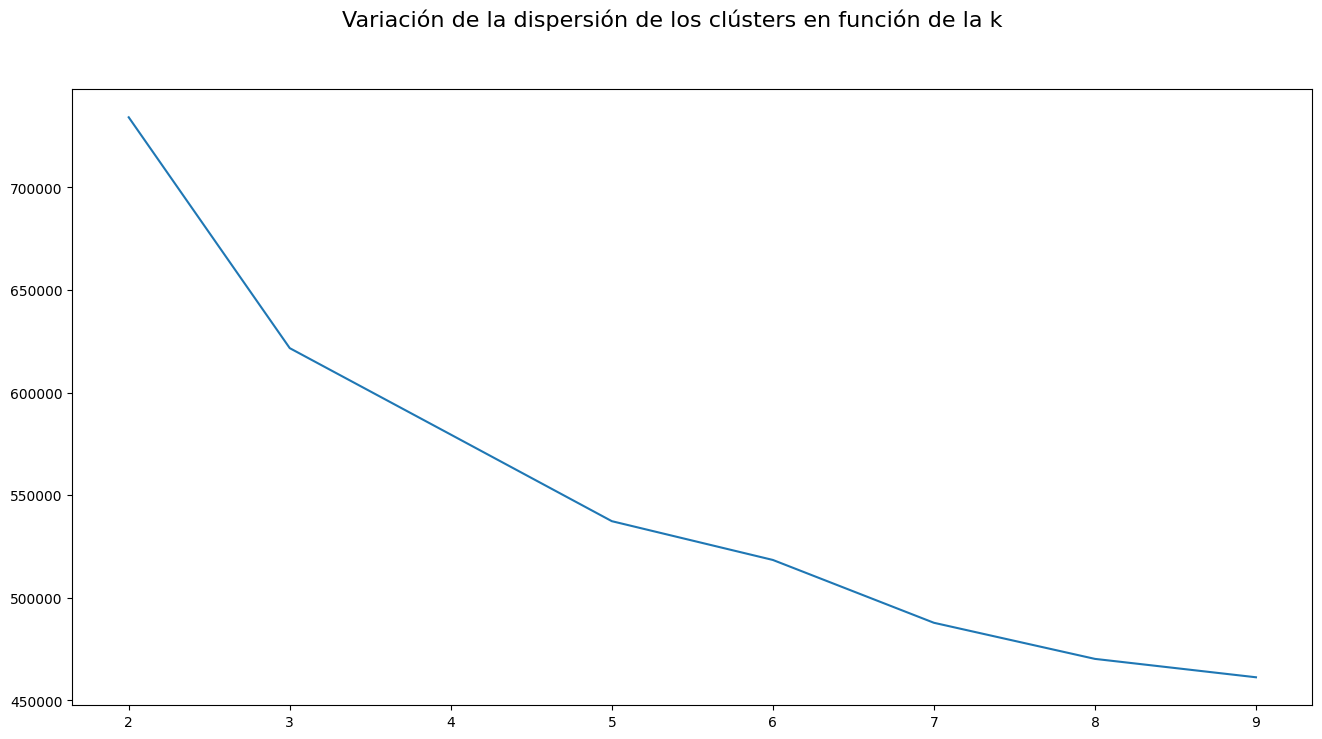

In [936]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

El codo aparece en el X, donde está el cambio más abrupto. En el Y y en el Z hay otra inflexion pero es muy leve, pero el cambio más grande es el X.
Si aparecen codos ascendentes, es raro así que solo cogeremos los codos que son descendentes.

## Segmentación de clientes con el K definido

### Filtramos el pipe con la K adecuada segun el numero de centroides

Definimos el nuevo pipe con los mismos parámetros y adadimos el clustering con la K adecuada. Ponemos random_state para que se puedan replicar los datos cada vez que se ejecuta.

In [937]:
pipe = Pipeline(steps = [
    #("Imputer", KNNImputer()),
    ("CustomTransformer", ClientIdFeatureGenerator),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 3, random_state = 175)) # Definir clusters con el num de centroides
])

In [938]:
df_final.shape

(236279, 39)

Tenemos X clientes, los que aparecen en la celde df_final.shape en el valor de X

### Hacemos un fit con el dataset final para aplicar las trasnformaciones correctas definidas en la pipe sobre el df

In [939]:
pipe.fit(df_final)

Pipeline(steps=[('CustomTransformer',
                 FunctionTransformer(func=<function df_final_function at 0x3299d9620>)),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=3, random_state=175))])

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados.

Hacemos el transform con el df final hasta el 2, por ejemplo

In [940]:
X_processed = pipe[:1].transform(df_final)
#X_processed = pipe.transform(df_final)

Hacemos el predict para definir las etiquetas de cadauno de los clusters.

In [941]:
labels = pipe.predict(df_final) # le hacemos las labels sobre el df_final, no sobre el escalado, ya que sino será dificil de interpretar etiquetas

In [942]:
# le asignamos el clúster al DataFrame procesado 
X_processed["cluster"] = labels

juntamos las labels con el dataset

In [943]:
X_processed.shape

(236279, 40)

## Ficha de los clientes

Tenemos quw resumir la info para describir los clusters.
Generamos el df ficha_df

In [944]:
ficha_df = pd.DataFrame()

Hacemos el resumen con el cluster al que añadimos las columnas mencionadas en el enumerate, que se añade al df de ficha final con el concat

***TENDREMOS QUE AÑADIR LAS VARIABLES NUEVAS***

In [945]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             236279 non-null  int64  
 1   region_code                 236279 non-null  int64  
 2   age                         236279 non-null  int64  
 3   salary                      236279 non-null  float64
 4   short_term_deposit          236279 non-null  int64  
 5   loans                       236279 non-null  int64  
 6   mortgage                    236279 non-null  int64  
 7   funds                       236279 non-null  int64  
 8   securities                  236279 non-null  int64  
 9   long_term_deposit           236279 non-null  int64  
 10  em_account_pp               236279 non-null  int64  
 11  credit_card                 236279 non-null  int64  
 12  payroll                     236279 non-null  float64
 13  pension_plan  

In [946]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236279 entries, 0 to 236278
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             236279 non-null  int64  
 1   region_code                 236279 non-null  int64  
 2   age                         236279 non-null  int64  
 3   salary                      236279 non-null  float64
 4   short_term_deposit          236279 non-null  int64  
 5   loans                       236279 non-null  int64  
 6   mortgage                    236279 non-null  int64  
 7   funds                       236279 non-null  int64  
 8   securities                  236279 non-null  int64  
 9   long_term_deposit           236279 non-null  int64  
 10  em_account_pp               236279 non-null  int64  
 11  credit_card                 236279 non-null  int64  
 12  payroll                     236279 non-null  float64
 13  pension_plan  

In [947]:
for i, col in enumerate(["active_customer", "age", "salary", "total_products","entry_channel_KAT", "entry_channel_KFA", "entry_channel_KFC","entry_channel_KHE","entry_channel_KHK","entry_channel_KHM","entry_channel_KHN","entry_channel_KHQ","entry_channel_Others","entry_channel_RED","segment_01 - TOP","segment_02 - PARTICULARES","segment_03 - UNIVERSITARIO","segment_Not defined"]): # Meter en la lista las columnas que creamos que nos describen al cliente para ver sobre los clusters en que varian y poder describirlos.
    # ['active_customer', 'entry_channel', 'total_products', ....]
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

???????!!!!cuando hagamos transformación de region code por números que representen la población, incluirlo también arriba

In [948]:
ficha_df

cluster                                     0             1             2
active_customer            mean  9.982977e-01  6.690598e-01  7.148055e-01
                           std   4.122473e-02  4.705544e-01  4.515094e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   1.000000e+00  0.000000e+00  0.000000e+00
                           50%   1.000000e+00  1.000000e+00  1.000000e+00
                           75%   1.000000e+00  1.000000e+00  1.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
age                        mean  3.693442e+01  3.256329e+01  3.457349e+01
                           std   1.092782e+01  1.429364e+01  1.372878e+01
                           min   3.000000e+00  5.000000e+00  4.000000e+00
                           25%   2.900000e+01  2.100000e+01  2.300000e+01
                           50%   3.500000e+01  2.700000e+01  3.200000e+01
                           75%   4.300000e+01  3.900000e+01  4.200000e+01
                           max   9.900000e+01  1.020000e+02  1.020000e+02
salary                     mean  7.527344e+04  6.116985e+04  6.084315e+04
                           std   2.530208e+05  1.618514e+05  1.119484e+05
                           min  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           25%  -1.000000e+00 -1.000000e+00 -1.000000e+00
                           50%   5.890185e+04  3.315549e+04  3.892344e+04
                           75%   1.039347e+05  9.354612e+04  9.416772e+04
                           max   2.889440e+07  1.571172e+07  1.326862e+07
total_products             mean  3.683518e+00  1.296024e+00  1.361099e+00
                           std   1.077652e+00  6.857205e-01  7.674693e-01
                           min   1.000000e+00  0.000000e+00  0.000000e+00
                           25%   3.000000e+00  1.000000e+00  1.000000e+00
                           50%   4.000000e+00  1.000000e+00  1.000000e+00
                           75%   4.000000e+00  2.000000e+00  2.000000e+00
                           max   9.000000e+00  6.000000e+00  7.000000e+00
entry_channel_KAT          mean  9.362909e-02  4.789939e-02  5.023638e-02
                           std   2.913145e-01  2.135546e-01  2.184335e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFA          mean  2.376408e-02  1.575906e-02  1.325183e-02
                           std   1.523146e-01  1.245427e-01  1.143519e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KFC          mean  2.195684e-01  6.495076e-02  9.901325e-02
                           std   4.139578e-01  2.464404e-01  2.986814e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
                           50%   0.000000e+00  0.000000e+00  0.000000e+00
                           75%   0.000000e+00  0.000000e+00  0.000000e+00
                           max   1.000000e+00  1.000000e+00  1.000000e+00
entry_channel_KHE          mean  1.098788e-01  9.551160e-02  8.019841e-02
                           std   3.127413e-01  2.939220e-01  2.716016e-01
                           min   0.000000e+00  0.000000e+00  0.000000e+00
                           25%   0.000000e+00  0.000000e+00  0.000000e+00
    

Generamos indices y renombramos las variables para quea facil de entender, Generamos multiindice para visualización

In [949]:
# generamos nuestro multiindex
out_index = [
    "Monetarios",
    "Fidelización",
    "Fidelización",
    "Logística"
]

inner_index = [
    "Importe",
    "Nr. de compras",
    "Última compra",
    "Retrasos"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [950]:
# Calculate the expected length of new_multi_index
expected_length = len(new_multi_index)

# Assuming ficha_df is your dataframe
num_columns = ficha_df.shape[0]

# Adjust new_multi_index if it is longer than the number of columns in ficha_df
if expected_length > num_columns:
    new_multi_index = new_multi_index[:num_columns]
else:
    # If it is shorter, repeat the index to match the number of columns
    while len(new_multi_index) < num_columns:
        new_multi_index.extend(new_multi_index[:num_columns - len(new_multi_index)])


In [951]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 126 entries, ('active_customer', 'mean') to ('segment_Not defined', 'max')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       126 non-null    float64
 1   1       126 non-null    float64
 2   2       126 non-null    float64
dtypes: float64(3)
memory usage: 4.3+ KB


In [952]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [953]:
ficha_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 126 entries, ('active_customer', 'mean') to ('segment_Not defined', 'max')
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       126 non-null    float64
 1   1       126 non-null    float64
 2   2       126 non-null    float64
dtypes: float64(3)
memory usage: 4.3+ KB


In [954]:
print(f"Length of index_ficha: {len(index_ficha)}")
print(f"Length of new_multi_index: {len(new_multi_index)}")
print(f"ficha_df shape: {ficha_df.shape}")

Length of index_ficha: 3
Length of new_multi_index: 126
ficha_df shape: (126, 3)


In [961]:
new_multi_index

[('Monetarios', 'Importe', 'Media'),
 ('Monetarios', 'Importe', 'Desviación'),
 ('Monetarios', 'Importe', 'Mínimo'),
 ('Monetarios', 'Importe', 'Perc. 25'),
 ('Monetarios', 'Importe', 'Perc. 50'),
 ('Monetarios', 'Importe', 'Perc. 75'),
 ('Monetarios', 'Importe', 'Máximo'),
 ('Fidelización', 'Nr. de compras', 'Media'),
 ('Fidelización', 'Nr. de compras', 'Desviación'),
 ('Fidelización', 'Nr. de compras', 'Mínimo'),
 ('Fidelización', 'Nr. de compras', 'Perc. 25'),
 ('Fidelización', 'Nr. de compras', 'Perc. 50'),
 ('Fidelización', 'Nr. de compras', 'Perc. 75'),
 ('Fidelización', 'Nr. de compras', 'Máximo'),
 ('Fidelización', 'Última compra', 'Media'),
 ('Fidelización', 'Última compra', 'Desviación'),
 ('Fidelización', 'Última compra', 'Mínimo'),
 ('Fidelización', 'Última compra', 'Perc. 25'),
 ('Fidelización', 'Última compra', 'Perc. 50'),
 ('Fidelización', 'Última compra', 'Perc. 75'),
 ('Fidelización', 'Última compra', 'Máximo'),
 ('Logística', 'Retrasos', 'Media'),
 ('Logística', 'Ret

In [955]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [956]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [957]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

In [958]:
### Renombramos clusters si queremos
# ficha_df = ficha_df.rename(columns = {
#     0 : "Clientes con pedidos < 1 año",
#     1 : "Clientes con pedidos > 1 año",
#     2 : "Clientes Premium",
#     3 : "Clientes Repetidores",
#     4 : "Clientes con Retrasos"
# })

In [959]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

Así pintado es mas facil definir los clusters. Vemos:
- tamaño clusters (debería ser mas o menos equitativo): tebemos casi la mitad de registros en un cluster pero los demás está bien repartidos.
- En el monetario de cluster 3 vemos que el pago de esos clientes es muy alto, superior a los demás clusters con diferencia. A este cluster se le podría llamar clientes premium.
- En fidelización, vemos que el cluster 4 destaca x el numero de compras, son mas fieles.
- Para Fidelización de última compra, vemos que destaca el cluster 2 que son los clientes que menos compran y supera el año. Se podrian llamar clientes que han comprado hace más de un año (seran poco importantes). Puedo usar este clustering para hacer una campaá comercial y destinar productos a los otros clusterings. También vemos que el cluster 0 es el que más compra.
- Para logística y retrasos destaca el cluster 2 donde vemos que los retrasos (más negativo significa entrega adelantada) son menores y se suele entregar antes. Puede que estos clientes esten más descontentos con la empresa x el desajuste de tiempo y elegirlos para compensarlos.

## Conclusión

Los algoritmos no supervisados son herramientas **muy potentes** que cualquier data scientist debe tener a mano. Saber el funcionamiento y hacer la correcta implementación de estos puede permitir **extraer información muy valiosa y tomar mejores decisiones de negocio**. Hemos visto el algoritmo de KMeans que nos permiten crear **grupos homogéneos y accionables** de clientes y así mejorar los indicadores de la compañia.

Además de esto, hemos aprendido a utilizar los pipelines de sklearn para **automatizar al máximo el tratamiento de datos** así como implementar nuestros propios ***Transformers*** que puede ser utilizados dentro del pipeline.

### Eliminamos columnas que no aportan info y Creamos nuevas columnas de descripción de clientes a partir de las existentes

In [960]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
df_final.drop(columns=['pk_cid', 'pk_partition', 'net_margin'], inplace=True)